In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%load_ext autoreload
%autoreload 2

### Data pre-processing

In [48]:
train_path = "/Users/julienhorwood/Documents/Masters courses/IFT1630/Assignments/Assignment4/Data/train_rois4.npy"
test_path = "/Users/julienhorwood/Documents/Masters courses/IFT1630/Assignments/Assignment4/Data/test_rois4.npy"
label_path = "/Users/julienhorwood/Documents/Masters courses/IFT1630/Assignments/Assignment4/Data/train_labels.csv"
train_data = np.load(train_path, encoding='latin1')[:,1]
test_data = np.load(test_path, encoding='latin1')[:,1]
train_labels = pd.read_csv(label_path)
labels = np.array(train_labels)[:,1]
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
baseline_train = np.array([train_data[i].reshape(784) for i in range(len(train_data))])
Xtrain,Xvalid,ytrain, yvalid = train_test_split(baseline_train,labels, test_size= 0.1)
train_data = np.array([train_data[i].reshape(1,28,28) for i in range(len(train_data))])

### Training baselines

In [3]:
logreg= LogisticRegression(class_weight = "balanced", multi_class='multinomial', solver='saga')
nb = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=(100), learning_rate_init = 0.01, learning_rate = 'adaptive')

nb.fit(Xtrain,ytrain)
mlp.fit(Xtrain,ytrain)
logreg.fit(Xtrain,ytrain)

/anaconda/envs/fondements_ml/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

### Testing baselines

In [4]:
#Naive bayes predictions
nb_preds = nb.predict(Xvalid)
num_correct_nb= np.sum(nb_preds == yvalid)

#MLP Classifier predictions
mlp_preds = mlp.predict(Xvalid)
num_correct_mlp= np.sum(mlp_preds == yvalid)

#Logistic Regression predictions
logreg_preds = logreg.predict(Xvalid)
num_correct_logreg = np.sum(logreg_preds == yvalid)

In [5]:
print("Naive bayes accuracy: ", num_correct_nb/len(yvalid) * 100, "%")
print("Logistic Regression accuracy: ", num_correct_logreg/len(yvalid) * 100, "%")
print("MLP accuracy: ", num_correct_mlp/len(yvalid) * 100, "%")

Naive bayes accuracy:  32.4 %
Logistic Regression accuracy:  43.3 %
MLP accuracy:  51.2 %


### Convnet

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import random
from kaggle_model import cnn
import matplotlib.ticker as ticker

### Data Loading

In [44]:
class QuickDrawDataset(Dataset):

    def __init__(self, data_path, label_path, transform=None):
        self.data =  np.load(data_path, encoding='latin1')[:,1]
        train_labels =  pd.read_csv(label_path)
        train_labels = np.array(train_labels)[:,1]
        self.labels = LabelEncoder().fit_transform(train_labels)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx].reshape(1,28,28)
        target = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample,target

This is the shape of one batch torch.Size([64, 1, 28, 28])
target torch.Size([64])


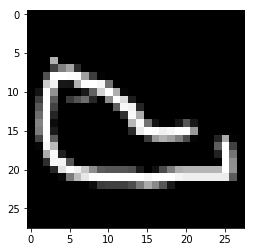

In [45]:
train_data_qd = QuickDrawDataset(train_path,label_path)
batch_size = 64
batch_size_eval = 512
n_valid = 1000
indices = list(range(len(train_data_qd)))
random.Random(0).shuffle(indices)

train_loader = DataLoader(
    train_data_qd,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[n_valid:])
)

valid_loader = DataLoader(
    train_data_qd,
    batch_size=batch_size_eval,
    sampler=SubsetRandomSampler(indices[:n_valid])
)

for inputs,targets in train_loader:
    print("This is the shape of one batch" ,inputs.shape)
    print("target", targets.shape)
    img = inputs[0,0]
    plt.imshow(img, cmap='Greys_r')
    break

### Train utilities

In [9]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

def train(model,train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
        
        # Let them code what's here
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        ###
        
        if batch_idx % 30 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader) *len(inputs) ,
                100. * batch_idx / len(train_loader), loss.item()))
def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    with torch.no_grad():
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            
            # let them code what's here
            output = model(inputs)
            test_size += len(inputs)
            test_loss += test_loss_fn(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    
    return test_loss, accuracy

cpu


### Model training

In [10]:
model = cnn.KaggleNet()
model = model.double()
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr = lr)

In [11]:
savedir = "logs/"

results = {'name':'trainlog', 'lr': lr, 'loss': [], 'accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(1, 10):
    train(model, train_loader, optimizer, epoch)
    loss, acc = test(model, valid_loader)
    
    # save results every epoch
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

Train Epoch: 1 [0/9024 (0%)]	Loss: 3.480928
Train Epoch: 1 [1920/9024 (21%)]	Loss: 2.117241
Train Epoch: 1 [3840/9024 (43%)]	Loss: 1.810395
Train Epoch: 1 [5760/9024 (64%)]	Loss: 1.912556
Train Epoch: 1 [7680/9024 (85%)]	Loss: 1.560696

Test set: Average loss: 1.3695, Accuracy: 629/1000 (63%)

Train Epoch: 2 [0/9024 (0%)]	Loss: 1.219432
Train Epoch: 2 [1920/9024 (21%)]	Loss: 0.952478
Train Epoch: 2 [3840/9024 (43%)]	Loss: 1.157557
Train Epoch: 2 [5760/9024 (64%)]	Loss: 1.342357
Train Epoch: 2 [7680/9024 (85%)]	Loss: 1.136717

Test set: Average loss: 1.0885, Accuracy: 700/1000 (70%)

Train Epoch: 3 [0/9024 (0%)]	Loss: 1.176301
Train Epoch: 3 [1920/9024 (21%)]	Loss: 1.098787
Train Epoch: 3 [3840/9024 (43%)]	Loss: 0.884909
Train Epoch: 3 [5760/9024 (64%)]	Loss: 0.775807
Train Epoch: 3 [7680/9024 (85%)]	Loss: 1.072829

Test set: Average loss: 1.0147, Accuracy: 734/1000 (73%)

Train Epoch: 4 [0/9024 (0%)]	Loss: 0.522433
Train Epoch: 4 [1920/9024 (21%)]	Loss: 0.864113
Train Epoch: 4 [3840/90

### Or just use skorch!

In [12]:
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit

In [13]:
# If a GPU is available, use it
# Pytorch uses an elegant way to keep the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False

#Run more epochs on GPU
net = NeuralNetClassifier(module=cnn.KaggleNet().double(), criterion=nn.CrossEntropyLoss, optimizer = optim.Adam, 
                          lr= 0.005, max_epochs = 5, train_split = CVSplit(0.1, random_state = 0)
                          , device = device, iterator_train__batch_size = 64, iterator_valid__batch_size=512)

In [14]:
net.fit(train_data,labels)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.6259       0.6560        1.2504  81.7749
      2        1.0818       0.6780        1.2407  81.7760
      3        0.8513       0.6890        1.1864  81.7960
      4        0.6726       0.6970        1.1819  81.8379
      5        0.4968       0.7330        1.0650  82.9253


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=KaggleNet(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout1): Dropout(p=0.2)
    (fc1): Linear(in_features=3136, out_features=512, bias=True)
    (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout2): Dropout(p=0.2)
    (fc2): Linear(in_features=512, out_features=31, bias=True)
  ),
)

#### Easily persist and load the model

In [15]:
net.save_params(f_params='Model outputs/model_params.pkl', f_history='Model outputs/model_history.pkl', f_optimizer='Model outputs/model_optimizer.pkl')

In [16]:
#Loading
net = NeuralNetClassifier(module = cnn.KaggleNet().double(), criterion = nn.CrossEntropyLoss)
net.initialize()
net.load_params('Model outputs/model_params.pkl', 
                f_history='Model outputs/model_history.pkl', f_optimizer='Model outputs/model_optimizer.pkl')

### Plotting and metrics

#### Learning curves

In [17]:
train_losses = net.history[:,'train_loss']
valid_losses = net.history[:, 'valid_loss']
accuracies = net.history[:, 'valid_acc']

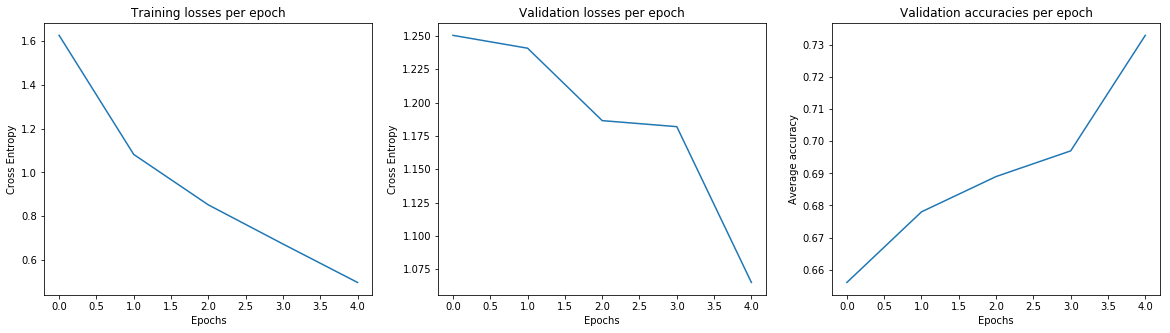

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (20,5))
ax1.set_title("Training losses per epoch")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Cross Entropy")
ax1.plot(train_losses)

ax2.set_title("Validation losses per epoch")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Cross Entropy")
ax2.plot(valid_losses)


ax3.set_title("Validation accuracies per epoch")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Average accuracy")
ax3.plot(accuracies)

fig.savefig("Analysis/learning_curves.png")

#### Confusion matrix

In [49]:
from sklearn.metrics import confusion_matrix

In [50]:
train,valid = CVSplit(0.1,random_state=0).__call__(train_data,labels)
Xvalid, yvalid = valid.dataset[valid.indices], labels[valid.indices]
preds = net.predict(Xvalid)
cm = confusion_matrix(y_pred= preds,y_true=yvalid)

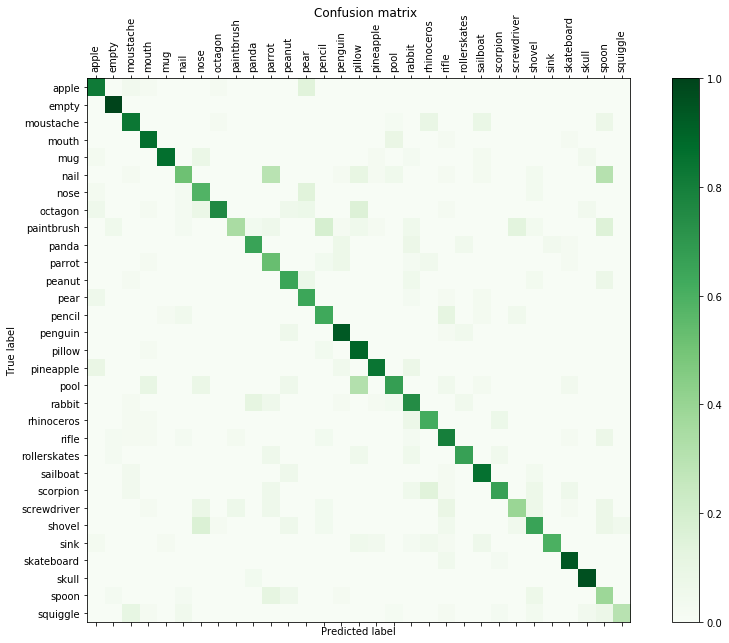

In [51]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
fig.suptitle('Confusion matrix')
cm = cm/cm.sum(axis=1)[: np.newaxis]
fig.colorbar(ax.matshow(cm,cmap = plt.cm.Greens))

#Fixing tick labels to add first and last dummy
ticks = [0]
ticks.extend(label_encoder.inverse_transform(range(31)))
ticks.append(0)

# Set up axes
ax.set_xticklabels(ticks, rotation=90)
ax.set_yticklabels(ticks)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

fig.savefig("Analysis/confusion_matrix.png")

#### Per class f1 and accuracy scores

In [53]:
from sklearn.metrics import precision_recall_fscore_support,classification_report
report = precision_recall_fscore_support(yvalid, preds)

#Compute class accuracies
class_acc = []
for i in range(31):
    idx = np.where(yvalid == i)
    class_acc.append(np.mean(preds[idx] == i).round(2))
    
out_dict = {
             "precision" : report[0].round(2)
            ,"recall" : report[1].round(2)
            ,"f1-score" : report[2].round(2)
            , "accuracy" : class_acc
            ,"support" : report[3]
            }
out_df = pd.DataFrame(out_dict, index = ticks[1:32])


    
#Compute average
averages = out_df.mean(axis = 0).round(2).to_frame().T
averages.index = ["average"]

#Compute weighted average
w_precision = (np.array(out_df.precision * out_df.support).sum()/(out_df.support.sum())).round(2)
w_recall = (np.array(out_df.recall * out_df.support).sum()/(out_df.support.sum())).round(2)
w_f1 = (np.array(out_df['f1-score'] * out_df.support).sum()/(out_df.support.sum())).round(2)
w_accuracy = (np.array(out_df.accuracy * out_df.support).sum()/(out_df.support.sum())).round(2)
w_support = np.mean(out_df.support).round(2)
w_averages = pd.DataFrame({'precision' : w_precision,'recall': w_recall, 
                           'f1-score': w_f1,'accuracy' : w_accuracy,'support': w_support},index=['weighted average'])
w_averages.index = ['weighted average']


out_df = out_df.append(averages)
out_df = out_df.append(w_averages)


out_df.to_csv("Analysis/validation_scoring.csv")
out_df

,precision,recall,f1-score,accuracy,support
apple,0.73,0.82,0.77,0.82,33.00
empty,0.89,1.00,0.94,1.00,39.00
moustache,0.71,0.83,0.76,0.83,47.00
mouth,0.77,0.86,0.81,0.86,50.00
mug,0.95,0.86,0.90,0.86,43.00
nail,0.70,0.51,0.59,0.51,41.00
nose,0.54,0.58,0.56,0.58,12.00
octagon,0.93,0.76,0.84,0.76,50.00
paintbrush,0.79,0.34,0.48,0.34,32.00
panda,0.77,0.65,0.71,0.65,26.00
